In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = '/home/omarioni/'
# path = '/home/ornela/PYTHON/'

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
# time_M31gd = M31_gd[:,0]
lbar_M31gd = M31_gd[:,1]

#------------------------------------------------------------------------------------------
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime.dat')
# time_M31gs = M31_gs[:,0]
lbar_M31gs = M31_gs[:,1]

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime.dat')
# time_MWgs = MW_gs[:,0]
lbar_MWgs = MW_gs[:,1]


### Calculo omega bar M31GD

In [4]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
# from __future__ import unicode_literals
from matplotlib.ticker import MultipleLocator
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

# path = '/home/ornela/SimCLUES/'
path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]

Path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,300,-1)
for isnap in snapshot:
#     Path = '/home/ornela/SimCLUES/'
    snap = h5py.File(Path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        IDs  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Ids'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i]) + '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'].value
        
        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
        ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
        zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
        
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h

        r200 = r200*aexp[isnap]/h
        rgal = 0.15*r200

        limit = np.where(rstr<rgal)
        r_sort = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        cincuenta, = np.where(razon < 0.5)

        r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
        veloc,=np.where(rstr<r50)

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        rn = np.sqrt(xn**2 + yn**2)
        Vtg = (-yn*vxn + xn*vyn)/rn
            
#------------------------------------------------------------------
        rtot = concatenate([rstr, rgas, rdrk])
        mtot = concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
#--------------------------------------------------------------
        
        mask_supreme, = np.where((rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))
    
        med, nodos = bine.rbin1(rn[mask_supreme],20)
    
#         vtan_mean   = np.zeros(len(med))
        omega_mean   = np.zeros(len(med))
        
        omega = Vtg/rn
        
        for i in range(0,len(med)):
            mask, = np.where((rn[mask_supreme] > nodos[i]) & (rn[mask_supreme] < nodos[i+1]))
#             vtan_mean[i] = np.mean(Vtg[mask_supreme][mask])
            omega_mean[i] = np.mean(omega[mask_supreme][mask])

#         finterp1 = sint.interp1d(med,vtan_mean)
#         omega_r = finterp1(lbar_M31gd[496-isnap])/med
#         omega_bar = finterp1(lbar_M31gd[496-isnap])/lbar_M31gd[496-isnap]
#         print omega_bar

        finterp2 = sint.interp1d(med,omega_mean)
        omegabar = finterp2(lbar_M31gd[496-isnap])

        omega_circ= Vtot/rtot_sort
        finterp3 = sint.interp1d(omega_circ,rtot_sort)
#         rcorot1 = finterp3(omega_bar)
        rcorot = finterp3(omegabar)

#--------------------------------------------------------------------
        path = '/home/omarioni/'
#         path = '/home/ornela/PYTHON/'
        archivo =  open(path + 'Barras_GdGs/Barras_Gd/_data/patternvstime.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                    str('%12.6f'% omegabar) +'\t'+
                    str('%12.6f'% rcorot) +'\n')
        archivo.close()

#-------------------------------------------------------------------------


/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in divide
/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in divide


## Hacemos los plots de los omega

In [1]:
import numpy as np
path = '/home/omarioni/'
# path = '/home/ornela/PYTHON/'

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/patternvstime.dat')
time_M31gd  = M31_gd[:,0]
omega_M31gd = M31_gd[:,1]
rcor_M31gd  = M31_gd[:,2]
print  'M31-GD = ', rcor_M31gd[0]

M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_patternvstime.dat')
time_M31gs  = M31_gs[:,0]
omega_M31gs = M31_gs[:,1]
rcor_M31gs = M31_gs[:,2]
print  'M31-GS = ', rcor_M31gs[0]

MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_patternvstime.dat')
time_MWgs  = MW_gs[:,0]
omega_MWgs = MW_gs[:,1]
rcor_MWgs  = MW_gs[:,2]
print  'MW-GS = ', rcor_MWgs[0]


M31-GD =  2.206218
M31-GS =  1.793746
MW-GS =  4.936894


[ 8.16823908  8.84929622  9.61688098 10.48459376 11.46854229 12.58803176
 13.86663323]


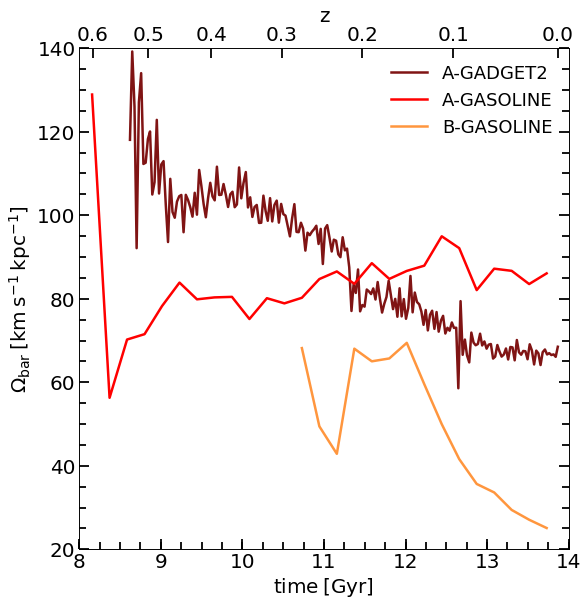

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter


fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

ax1=fig.add_subplot(111)
ax1.plot(time_M31gd, omega_M31gd, '-', lw=2.5, color='#801414', label='A-GADGET2')
ax1.plot(time_M31gs, omega_M31gs, '-', lw=2.5, color='#FF0000', label='A-GASOLINE')
ax1.plot(time_MWgs, omega_MWgs,   '-', lw=2.5, color='#FF963E', label='B-GASOLINE')
# ax1.plot(tt, veloc_ang*2*np.pi/360., '-', color='k')
ax1.set_xticks([8,9,10,11,12,13,14])
ax1.set_xlim(8,14)
ax1.set_ylim(20,140)
ax1.set_xlabel('$\mathrm{time\:[Gyr]}$', fontsize=20)
ax1.set_ylabel('$\mathrm{\Omega_{bar}\:[km\:s^{-1}\:kpc^{-1}]}$', fontsize=20)
ax1.minorticks_on()
ax1.tick_params( labelsize=20)
ax1.tick_params('both', length=7, width=1.8,which='minor', direction='in', right='on',top='off')
ax1.tick_params('both', length=10, width=1.8,which='major', direction='in', right='on',top='off')
ax1.xaxis.set_minor_locator(MultipleLocator(1/4.)) 
ax1.legend(fontsize=18,frameon=False, loc=1)

ax2 = ax1.twiny()
new_tick_label = np.array([0.6,0.5,0.4,0.3,0.2,0.1,0])
ticks_pos = tiempo.conv(new_tick_label, h, omega_lambda, omega_matter)
print ticks_pos
ax2.set_xticks(ticks_pos)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticklabels(new_tick_label)
ax2.set_xlabel('z',fontsize=20)
ax2.tick_params( labelsize=20)
ax2.tick_params('both', length=7, width=1.8,which='minor', direction='in', right='on',top='on')
ax2.tick_params('both', length=10, width=1.8,which='major', direction='in', right='on',top='on')

fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/omega_time_conz.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

In [9]:
ax2.get_xlim()

(7.284063698291929, 14.0)

In [12]:
cm = np.loadtxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/new_phi_time.dat')
# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/new_phi_time.dat')
time =cm[:,1]
phi =cm[:,2]

kk = len(phi)-1

delta_phi = np.zeros(len(phi))
delta_t = np.zeros(len(phi))
tt = np.zeros(len(phi))

for i in range(kk,0,-1):
    delta_t [i]  = time[i-1] - time[i]
    delta_phi[i] = phi[i-1] - phi[i]
    tt[i] = (time[i-1] + time[i]) / 2.

delta_t   = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc_ang = delta_phi/delta_t

### radios de corotacion

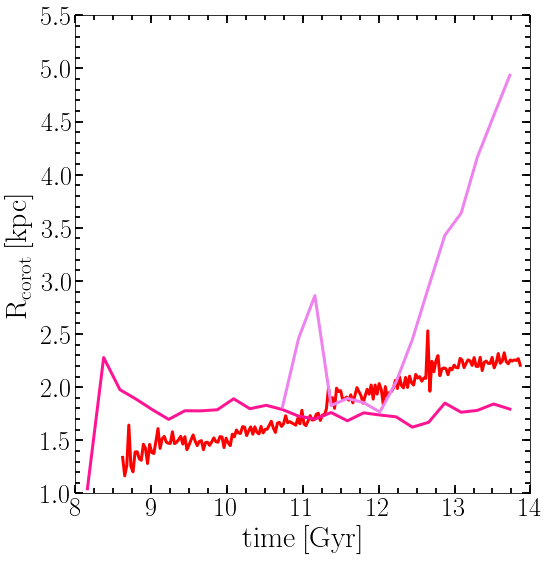

In [25]:
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(time_M31gd, rcor_M31gd, '-', lw=3, color='r')
ax1.plot(time_M31gs, rcor_M31gs, '-', lw=3,color='deeppink')
ax1.plot(time_MWgs, rcor_MWgs, '-', lw=3,color='violet')
ax1.set_xticks([8,9,10,11,12,13,14])
ax1.set_xlim(8,14)
ax1.set_ylim(1,5.5)
ax1.set_xlabel('$\mathrm{time\:[Gyr]}$', fontsize=30)
ax1.set_ylabel('$\mathrm{R_{corot}\:[kpc]}$', fontsize=30)
ax1.minorticks_on()
ax1.tick_params( labelsize=26)
ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax1.xaxis.set_minor_locator(MultipleLocator(1/4.)) 
ax1.yaxis.set_minor_locator(MultipleLocator(1/10.)) 

fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/rcorot_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

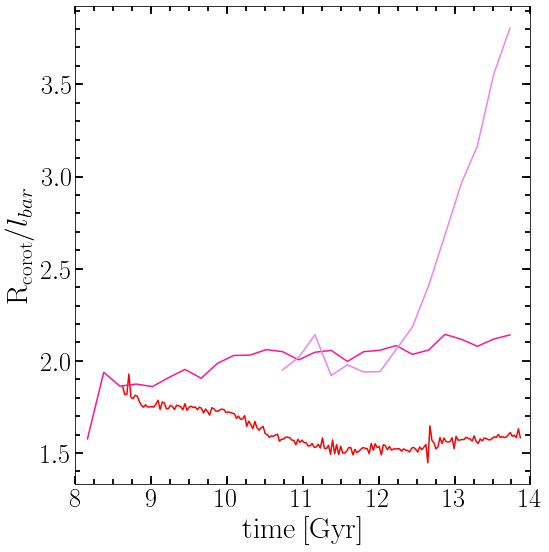

In [23]:
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(time_M31gd, rcor_M31gd/lbar_M31gd, '-', color='r')
ax1.plot(time_M31gs, rcor_M31gs/lbar_M31gs, '-', color='deeppink')
ax1.plot(time_MWgs, rcor_MWgs/lbar_MWgs, '-', color='violet')
ax1.set_xticks([8,9,10,11,12,13,14])
ax1.set_xlim(8,14)
# ax1.set_ylim(1,5.5)
ax1.set_xlabel('$\mathrm{time\:[Gyr]}$', fontsize=30)
ax1.set_ylabel('$\mathrm{R_{corot}}/l_{\mathr{bar}}$', fontsize=30)
ax1.minorticks_on()
ax1.tick_params( labelsize=26)
ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax1.xaxis.set_minor_locator(MultipleLocator(1/4.)) 
# ax1.yaxis.set_minor_locator(MultipleLocator(1/8.)) 

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/rcorot_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

### Calculo omega bar M31GS

In [18]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from __future__ import unicode_literals
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')

for j in range(len(snapshot)-1,32,-1):
    
#     path = '/home/ornela/SimCLUES/'
    path = '/mnt/sersic2/omarioni/'
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    cm   = snap['subhalo_001/Center'].value
    r200 = snap['subhalo_001/R200'].value
    time = snap['subhalo_001/Time'].value
    h    = snap['subhalo_001/h'].value
    aexp = snap['subhalo_001/aexp'].value
    
    pstr = snap['subhalo_001/Str/Coordinates'].value
    mstr = snap['subhalo_001/Str/Masses'].value
    vel  = snap['subhalo_001/Str/Velocities'].value
    
    pgas = snap['subhalo_001/Gas/Coordinates'].value
    mgas = snap['subhalo_001/Gas/Masses'].value

    pdrk = snap['subhalo_001/Drk/Coordinates'].value
    mdrk = snap['subhalo_001/Drk/Masses'].value
    
#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2)
    Vtg = (-yn*vxn + xn*vyn)/rn

#------------------------------------------------------------------
    rtot = concatenate([rstr, rgas, rdrk])
    mtot = concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt(G*Mc_tot/rtot_sort)
#--------------------------------------------------------------

    mask_supreme, = np.where((rn<3.*aexp) & (zn<1.*aexp) & (zn>-1.*aexp))

    med, nodos = bine.rbin1(rn[mask_supreme],20)

#         vtan_mean   = np.zeros(len(med))
    omega_mean   = np.zeros(len(med))

    omega = Vtg/rn

    for i in range(0,len(med)):
        mask, = np.where((rn[mask_supreme] > nodos[i]) & (rn[mask_supreme] < nodos[i+1]))
#             vtan_mean[i] = np.mean(Vtg[mask_supreme][mask])
        omega_mean[i] = np.mean(omega[mask_supreme][mask])

#         finterp1 = sint.interp1d(med,vtan_mean)
#         omega_r = finterp1(lbar_M31gd[496-isnap])/med
#         omega_bar = finterp1(lbar_M31gd[496-isnap])/lbar_M31gd[496-isnap]
#         print omega_bar

    finterp2 = sint.interp1d(med,omega_mean)
    omegabar = finterp2(lbar_M31gs[len(snapshot)-j-1])

    omega_circ= Vtot/rtot_sort
    finterp3 = sint.interp1d(omega_circ,rtot_sort)
#         rcorot1 = finterp3(omega_bar)
    rcorot = finterp3(omegabar)

#--------------------------------------------------------------------
    path = '/home/omarioni/'
#         path = '/home/ornela/PYTHON/'
    archivo =  open(path + 'Barras_GdGs/Barras_Gs/_data/M31_patternvstime.dat','a')
    archivo.write(str('%12.6f'% time) +'\t'+
                str('%12.6f'% omegabar) +'\t'+
                str('%12.6f'% rcorot) +'\n')
    archivo.close()


#-------------------------------------------------------------------------


/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in divide
/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in divide


In [19]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from __future__ import unicode_literals
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,44,-1):
    
#     path = '/home/ornela/SimCLUES/'
    path = '/mnt/sersic2/omarioni/'
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    cm   = snap['subhalo_002/Center'].value
    r200 = snap['subhalo_002/R200'].value
    time = snap['subhalo_002/Time'].value
    h    = snap['subhalo_002/h'].value
    aexp = snap['subhalo_002/aexp'].value
    
    pstr = snap['subhalo_002/Str/Coordinates'].value
    mstr = snap['subhalo_002/Str/Masses'].value
    vel  = snap['subhalo_002/Str/Velocities'].value
    
    pgas = snap['subhalo_002/Gas/Coordinates'].value
    mgas = snap['subhalo_002/Gas/Masses'].value

    pdrk = snap['subhalo_002/Drk/Coordinates'].value
    mdrk = snap['subhalo_002/Drk/Masses'].value
    
#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)
    
    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2)
    Vtg = (-yn*vxn + xn*vyn)/rn

#------------------------------------------------------------------
    rtot = concatenate([rstr, rgas, rdrk])
    mtot = concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt(G*Mc_tot/rtot_sort)
#--------------------------------------------------------------

    mask_supreme, = np.where((rn<3.*aexp) & (zn<1.*aexp) & (zn>-1.*aexp))

    med, nodos = bine.rbin1(rn[mask_supreme],20)

#         vtan_mean   = np.zeros(len(med))
    omega_mean   = np.zeros(len(med))

    omega = Vtg/rn

    for i in range(0,len(med)):
        mask, = np.where((rn[mask_supreme] > nodos[i]) & (rn[mask_supreme] < nodos[i+1]))
#             vtan_mean[i] = np.mean(Vtg[mask_supreme][mask])
        omega_mean[i] = np.mean(omega[mask_supreme][mask])

#         finterp1 = sint.interp1d(med,vtan_mean)
#         omega_r = finterp1(lbar_M31gd[496-isnap])/med
#         omega_bar = finterp1(lbar_M31gd[496-isnap])/lbar_M31gd[496-isnap]
#         print omega_bar

    finterp2 = sint.interp1d(med,omega_mean)
    omegabar = finterp2(lbar_MWgs[len(snapshot)-j-1])

    omega_circ= Vtot/rtot_sort
    finterp3 = sint.interp1d(omega_circ,rtot_sort)
#         rcorot1 = finterp3(omega_bar)
    rcorot = finterp3(omegabar)

#--------------------------------------------------------------------
    path = '/home/omarioni/'
#         path = '/home/ornela/PYTHON/'
    archivo =  open(path + 'Barras_GdGs/Barras_Gs/_data/MW_patternvstime.dat','a')
    archivo.write(str('%12.6f'% time) +'\t'+
                str('%12.6f'% omegabar) +'\t'+
                str('%12.6f'% rcorot) +'\n')
    archivo.close()
#-------------------------------------------------------------------------
 

/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in divide
/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in divide
